**UC Merced Remote Sensing Image Captioning Model Training**

Reference : https://cs.stanford.edu/people/karpathy/cvpr2015.pdf

Model is written on the similar lines of Flickr dataset Image Captioning Model, acquired from this blog : https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/



In [0]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import numpy as np
from numpy import array
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import string
import os
import pickle
from PIL import Image
import glob
from pickle import dump, load
from time import time
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import LSTM, Embedding, TimeDistributed, Dense, RepeatVector,\
                         Activation, Flatten, Reshape, concatenate, Dropout, BatchNormalization
from keras.optimizers import Adam, RMSprop
from keras.layers.wrappers import Bidirectional
from keras.layers.merge import add
from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras import Input, layers
from keras import optimizers
from keras.applications.inception_v3 import preprocess_input
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

Using TensorFlow backend.


**Loading Image Captions**




In [0]:
# load doc into memory
def load_doc(filename):
	# open the file as read only
	file = open(filename, 'r')
	# read all text
	text = file.read()
	# close the file
	file.close()
	return text

filename = "/content/drive/My Drive/Colab Notebooks/ucmercedcaptions.txt"
# load descriptions
doc = load_doc(filename)
print(doc[:300])

1.tif#0	There is a piece of farmland .
1.tif#1	There is a piece of cropland .
1.tif#2	It is a piece of farmland .
1.tif#3	It is a piece of cropland .
1.tif#4	Here is a piece of farmland .
2.tif#0	There is a piece of farmland .
2.tif#1	There is a piece of cropland .
2.tif#2	It is a piece of farmland 


**Creating a dictionary which contains the name of the image (without the .jpg extension) as keys and a list of the 5 captions for the corresponding image as values.**


In [0]:
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# extract filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))

Loaded: 2100 


In [0]:
list(descriptions.keys())[:5]

['1', '2', '3', '4', '5']

In [0]:
descriptions['115']

['There is an airplane on the runway .',
 'An airplane is taxiing on the runway .',
 'It is an airplane taxiing on the runway .',
 'There is an airplane taxiing on the runway .',
 'A blue airplane is taxiing on the runway .']

In [0]:
descriptions['377']

['This is a beach with green-blue sea and sands .',
 'The beach is peaceful with green-blue waters and white sands .',
 'A peaceful white sand beach with clear green waters .',
 'This is a peaceful beach with white sands and green waters .',
 'A beautiful beach with white sands and green waters .']

**Cleaning the captions by removing punctuations.**


In [0]:
def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# clean descriptions
clean_descriptions(descriptions)

In [0]:
descriptions['377']

['this is beach with greenblue sea and sands',
 'the beach is peaceful with greenblue waters and white sands',
 'peaceful white sand beach with clear green waters',
 'this is peaceful beach with white sands and green waters',
 'beautiful beach with white sands and green waters']

In [0]:
descriptions['115']

['there is an airplane on the runway',
 'an airplane is taxiing on the runway',
 'it is an airplane taxiing on the runway',
 'there is an airplane taxiing on the runway',
 'blue airplane is taxiing on the runway']

**Creating a vocabulary of all the unique words present across all the captions**

In [0]:
# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 333


In [0]:
# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()

save_descriptions(descriptions, 'descriptions.txt')

**Reading training data**

In [0]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

# load training dataset (6K)
filename = '/content/drive/My Drive/Colab Notebooks/ucmercedtrain.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 1890


In [0]:
# Below path contains all the images
images = '/content/drive/My Drive/Colab Notebooks/imgs/'
# Create a list of all image names in the directory
img = glob.glob(images + '*.tif')

In [0]:
# Below file conatains the names of images to be used in train data
train_images_file = '/content/drive/My Drive/Colab Notebooks/ucmercedtrain.txt'
# Read the train image names in a set
train_images = set(open(train_images_file, 'r').read().strip().split('\n'))

# Create a list of all the training images with their full path names
train_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in train_images: # Check if the image belongs to training set
        train_img.append(i) # Add it to the list of train images

**Reading Test data**

In [0]:
# Below file conatains the names of images to be used in test data
test_images_file = '/content/drive/My Drive/Colab Notebooks/ucmercedtest.txt'
# Read the validation image names in a set# Read the test image names in a set
test_images = set(open(test_images_file, 'r').read().strip().split('\n'))

# Create a list of all the test images with their full path names
test_img = []

for i in img: # img is list of full path names of all images
    if i[len(images):] in test_images: # Check if the image belongs to test set
        test_img.append(i) # Add it to the list of test images

**Wraping captions with "startseq" and "endseq" keyword**

In [0]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=1890


**Preprocessing Image data**

In [0]:
def preprocess(image_path):
    # Convert all the images to size 299x299 as expected by the inception v3 model
    img = image.load_img(image_path, target_size=(299, 299))
    # Convert PIL image to numpy array of 3-dimensions
    x = image.img_to_array(img)
    # Add one more dimension
    x = np.expand_dims(x, axis=0)
    # preprocess the images using preprocess_input() from inception module
    x = preprocess_input(x)
    return x

**Using Standard CNN Model for Image feature Extraction : Inception V3 is used here**

In [0]:
# Load the inception v3 model
model = InceptionV3(weights='imagenet')









96116736/96112376 [==============================] - 4s 0us/step


In [0]:
# Create a new model, by removing the last layer (output layer) from the inception v3
model_new = Model(model.input, model.layers[-2].output)

In [0]:
# Function to encode a given image into a vector of size (2048, )
def encode(image):
    image = preprocess(image) # preprocess the image
    fea_vec = model_new.predict(image) # Get the encoding vector for the image
    fea_vec = np.reshape(fea_vec, fea_vec.shape[1]) # reshape from (1, 2048) to (2048, )
    return fea_vec

In [0]:
# Call the funtion to encode all the train images
# This will take a while on CPU - Execute this only once
start = time()
encoding_train = {}
for img in train_img:
    encoding_train[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 815.412693977356


**Saving the training image features in pickle file**

In [0]:
# Save the bottleneck train features to disk
with open("/content/drive/My Drive/Colab Notebooks/UCPickle/uc_encoded_train_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_train, encoded_pickle)

**Repeating the above process for test images**

In [0]:
# Call the funtion to encode all the test images - Execute this only once
start = time()
encoding_test = {}
for img in test_img:
    encoding_test[img[len(images):]] = encode(img)
print("Time taken in seconds =", time()-start)

Time taken in seconds = 94.31381297111511


In [0]:
# Save the bottleneck test features to disk
with open("/content/drive/My Drive/Colab Notebooks/UCPickle/uc_encoded_test_images.pkl", "wb") as encoded_pickle:
    pickle.dump(encoding_test, encoded_pickle)

In [0]:
train_features = load(open("/content/drive/My Drive/Colab Notebooks/UCPickle/uc_encoded_train_images.pkl", "rb"))
print('Photos: train=%d' % len(train_features))

Photos: train=1890


In [0]:
# Create a list of all the training captions
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)
len(all_train_captions)

9450

**Next, we consider only those words which occur at least 10 times in the entire corpus.**


In [0]:
# Consider only words which occur at least 10 times in the corpus
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:
    nsents += 1
    for w in sent.split(' '):
        word_counts[w] = word_counts.get(w, 0) + 1

vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]
print('preprocessed words %d -> %d' % (len(word_counts), len(vocab)))

preprocessed words 333 -> 249


**Every word is given index and every index is given a word, 2 dictionaries to map both of these is created**

In [0]:
ixtoword = {}
wordtoix = {}

ix = 1
for w in vocab:
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

In [0]:
vocab_size = len(ixtoword) + 1 # one for appended 0's
vocab_size

250

**Finding out the maximum length of caption present in the corpus**

In [0]:
# convert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

# calculate the length of the description with the most words
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

# determine the maximum sequence length
max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Description Length: 23


**Data generator for training data to be passed to the model**

In [0]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list()
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.tif']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)
            # yield the batch data
            if n==num_photos_per_batch:
                yield [[array(X1), array(X2)], array(y)]
                X1, X2, y = list(), list(), list()
                n=0

**Now, we will map the every word (index) to a 200-long vector and for this purpose, we will use a pre-trained GLOVE Model**

In [0]:
# Load Glove vectors
glove_dir = '/content/drive/My Drive/Colab Notebooks/glove'
embeddings_index = {} # empty dictionary
f = open(os.path.join(glove_dir, 'glove.6B.200d.txt'), encoding="utf-8")

for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [0]:
embedding_dim = 200

# Get 200-dim dense vector for each of the 10000 words in out vocabulary
embedding_matrix = np.zeros((vocab_size, embedding_dim))

for word, i in wordtoix.items():
    #if i < max_words:
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in the embedding index will be all zeros
        embedding_matrix[i] = embedding_vector

In [0]:
embedding_matrix.shape

(250, 200)

**Final Image Captioning Model**

In [0]:
# image feature extractor model
inputs1 = Input(shape=(2048,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

# partial caption sequence model
inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# decoder (feed forward) model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# merge the two input models
model = Model(inputs=[inputs1, inputs2], outputs=outputs)

Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [0]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 23)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 2048)         0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 23, 200)      50000       input_3[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 2048)         0           input_2[0][0]                    
____________________________________________________________________________________________

In [0]:
model.layers[2]

In [0]:
model.layers[2].set_weights([embedding_matrix])
model.layers[2].trainable = False

**Training the model**

In [0]:
model.compile(loss='categorical_crossentropy', optimizer='adam')

In [0]:
epochs = 30
number_pics_per_bath = 6
steps = len(train_descriptions)//number_pics_per_bath

In [0]:
generator = data_generator(train_descriptions, train_features, wordtoix, max_length, number_pics_per_bath)
model_fit_history=model.fit_generator(generator, epochs=100, steps_per_epoch=steps, verbose=1)
   

Epoch 1/100
315/315 [==============================] - 30s 96ms/step - loss: 0.4252
Epoch 2/100
315/315 [==============================] - 29s 92ms/step - loss: 0.4274
Epoch 3/100
315/315 [==============================] - 30s 94ms/step - loss: 0.4304
Epoch 4/100
315/315 [==============================] - 29s 93ms/step - loss: 0.4424
Epoch 5/100
315/315 [==============================] - 30s 94ms/step - loss: 0.4616
Epoch 6/100
315/315 [==============================] - 29s 93ms/step - loss: 0.5080
Epoch 7/100
315/315 [==============================] - 30s 95ms/step - loss: 0.5580
Epoch 8/100
315/315 [==============================] - 29s 93ms/step - loss: 0.5671
Epoch 9/100
315/315 [==============================] - 29s 93ms/step - loss: 0.5805
Epoch 10/100
315/315 [==============================] - 30s 94ms/step - loss: 0.5615
Epoch 11/100
315/315 [==============================] - 30s 94ms/step - loss: 0.5492
Epoch 12/100
315/315 [==============================] - 30s 96ms/step - lo

**Saving the trained model and its weights**

In [0]:
model.save_weights('/content/drive/My Drive/Colab Notebooks/UC_model_weights/ucmodel_30.h5')

In [0]:
model.save('/content/drive/My Drive/Colab Notebooks/UC_model_weights/ucmodel.h5')

In [0]:
model.load_weights('/content/drive/My Drive/Colab Notebooks/UC_model_weights/ucmodel_30.h5')

In [0]:
images = '/content/drive/My Drive/Colab Notebooks/imgs/'

**Testing the image captions**

In [0]:
with open("/content/drive/My Drive/Colab Notebooks/UCPickle/uc_encoded_test_images.pkl", "rb") as encoded_pickle:
    encoding_test = load(encoded_pickle)

In [0]:
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break
    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

['2.tif', '2010.tif', '2015.tif', '2032.tif', '2035.tif', '2038.tif', '2058.tif', '2062.tif', '2086.tif', '2088.tif', '2094.tif', '210.tif', '214.tif', '212.tif', '217.tif', '259.tif', '267.tif', '281.tif', '290.tif', '284.tif', '285.tif', '302.tif', '31.tif', '307.tif', '305.tif', '322.tif', '319.tif', '345.tif', '349.tif', '373.tif', '388.tif', '395.tif', '421.tif', '44.tif', '446.tif', '450.tif', '459.tif', '465.tif', '471.tif', '473.tif', '469.tif', '491.tif', '500.tif', '5.tif', '504.tif', '517.tif', '547.tif', '545.tif', '542.tif', '548.tif', '578.tif', '584.tif', '597.tif', '599.tif', '607.tif', '613.tif', '616.tif', '652.tif', '658.tif', '663.tif', '665.tif', '674.tif', '675.tif', '690.tif', '703.tif', '706.tif', '718.tif', '73.tif', '735.tif', '750.tif', '765.tif', '759.tif', '768.tif', '776.tif', '788.tif', '8.tif', '806.tif', '804.tif', '822.tif', '832.tif', '844.tif', '859.tif', '86.tif', '864.tif', '88.tif', '888.tif', '886.tif', '895.tif', '9.tif', '902.tif', '912.tif', '

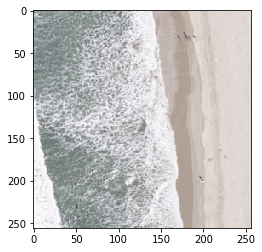

Greedy: waves slapping white sand beach throw up white foams


In [0]:
x1=list(encoding_test.keys())
print(x1)

pic = list(encoding_test.keys())[21]
print(pic)
image = encoding_test[pic].reshape((1,2048))
x=plt.imread(images+pic)
plt.imshow(x)
plt.show()
print("Greedy:",greedySearch(image))